# Problem Statement

**Buisness Problem and Context**

> The esports industry has experienced exponential growth with millions of fans, thousands of professional teams, and countless competitive tournaments and events worldwide. However, despite the rapid expansion within esports, teams and organizations often struggle with player performance analysis, fan engagement, and team-building decisions. There is a massive amount of data generated from games, streams, and player interactions with a potential for valuable insights that could enhance decision making for teams and improve viewer experience.

> One specific problem in this domain is optimizing player scouting and performance evaluation. By analyzing player data (such as gameplay metrics, reaction times, and decision-making patterns) teams would be able to better identify rising talent, create more balance rosters, and predict team performance and consistancy. Solving this problem can lead to improved team compositiion, enhanced performance in tournaments, and a more competitive edge.

**Value of Solving the Problem**

> Addressing this issue can provide many benefits:
1. Cost Saving: Effective player scouting and development can reduce recuitment costs by targeting only the most promising players. It is very expensive to sign a player and pay for all their expenses (relocation, housing, flights for tournaments, gathering content)
2. Increased Revenue: Building stronger teams attract more sponsorships and fan support, driving revenue through merchandize and viewership.
3. Improved Customer Satisfaction: Fans enjoy watching competitive teams with well-chosen players, leading to better fan engagement and loyalty.

**Stakeholders**

> Some of the key stakeholders include:
* Esports Teams and Organizations: They benefit from better player selection and team synergy
* Sponsors: Improved team performance leads to greater visibility and return on sponsorship investment.
* Fans: A more competitive roster enhances viewer engagement and loyality.

**Machine Learning Methods**

> This problem could be addressed using:
* Classification: To clasify players into different categories such as novice, intermediate, or elite based on performance metrics.
* Clustering: To identify natural groupings among players, revealing patterns or playstyles that might help for team synergy.
* Regression: To predict player performance metrics over time or their impact on the teams' success.

> Each method is suitable due to the need for robust analysis insights. Classification and clustering help segment the players based on their skill or playstyle, while regression could be used to estimate their long-term impact.

**Data Challenges and Risks**

>
* Data Quality and Availability: Player performance and data can vary drastically from game to game or by platform which may give inconsistant quality with noise and/or missing values. There are also a variety of data available for each game title, with some giving more public data than others which could be a hindrance when applying this to multiple game titles.
* Modeling Risks: Overfitting is a concern, espeically when given how complex things get with player behivors and the overall dynamic of competitive esports. Bias might emerge if data skews towards popular games or player demographics which would limit the model's generalizability.
* Deployment Challenges: The model's output needs to be interpretable and actionable for some of the more non-technical stakeholders such as managers. There is also a need for timely updates as metas and strategies often rapidly shift.


**Deployment and Buisness Usefullness**

> To make the model valuable, it might produce reliable results and insights that are simple for teams to apply in real-time player evaluations or team-building sessions. This model should be updated regularly to reflect the latest player data, ideally with each esports season (which varies based on the game title).

# Exploratory Data Analysis

**Data Description:**

> *Source:* The data is sourced through [Ballchasing.com](https://ballchasing.com), a Rocket League analytics platform that players can upload their match replays. Through their API, replay metadata and in-game metrics can be accessed.

> *Format:* The data is available in JSON format through API calls. Each replay provides some extensive gameplay metrics which includes player stats, team stats, and match metadata. For this analysis, the focus is on individual player performance metrics.

> *Samples and Features:*


*   For each run, 20 replays are fetched for a specified players with filters for professional lobbies only and/or a specific playlist (enum). Due to API limitations, some replays are not able to be retrieved, and the selection may vary with recent gameplay.

*   The selected features include (many more available at https://ballchasing.com/doc/api#replays-replay-get)...
 * isWinner: Whether the player's team won the match
 * goals: Goals scored by the player
 * shooting_percentage: Player’s shooting accuracy (%)
 * saves: Number of saves by the player
 * percent_full_boost: Percentage of time the player had full boost
 * percent_zero_boost: Percentage of time the player had no boost
 * avg_amount: Player’s average boost amount during the match
 * amount_collected_big: Large boost pads collected
 * amount_collected_small: Small boost pads collected
 * percent_behind_ball: Percentage of time the player was behind the ball
 * percent_infront_ball: Percentage of time the player was in front of the ball

**Imports**

In [30]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import ttest_ind
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    StratifiedKFold,
    cross_val_score,
)
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.utils import resample
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.manifold import TSNE

API_KEY = "ji4B6aCgxaMPdYsLg1o9x4rw5MZwjXDrRvFBJH29"
BASE_URL = "https://ballchasing.com/api"

Ballchasing API Script and Finding Replays

In [31]:
def fetch_replays(player_name=None, pro_only=False, playlist_id=None):
    """Fetch replays based on filters."""
    headers = {"Authorization": API_KEY}
    params = {'count': 50}

    # Apply filters
    if pro_only:
        params["pro"] = "true"
    if playlist_id:
        params["playlist"] = playlist_id
    if player_name:
        params["player-name"] = player_name

    # Make API request
    response = requests.get(f"{BASE_URL}/replays", headers=headers, params=params)
    if response.status_code != 200:
        print(f"Error: {response.status_code}, {response.text}")
        return None

    data = response.json()
    if "list" not in data:
        print("No replays found in response.")
        return None

    return data["list"]

def flatten_replay_data(replay_details, target_player):
    """Flatten nested columns to simplify the DataFrame."""
    if replay_details is None:
        return None

    player_stats = {}
    team = 'blue'

    blue_players = replay_details['blue']['players']
    for player in blue_players:
      if player['name'] == target_player:
        player_stats[replay_details['id']] = player['stats']

    orange_players = replay_details['orange']['players']
    for player in orange_players:
      if player['name'] == target_player:
        player_stats[replay_details['id']] = player['stats']
        team = 'orange'

    blueScore = replay_details['blue']['stats']['core']['goals']
    orangeScore = replay_details['orange']['stats']['core']['goals']

    if replay_details['id'] not in player_stats:
      return None

    return {
        'isWinner': team == 'blue' if blueScore > orangeScore else team == 'orange',
        'goals': player_stats[replay_details['id']]['core']['goals'],
        'shooting_percentage': player_stats[replay_details['id']]['core']['shooting_percentage'],
        'saves': player_stats[replay_details['id']]['core']['saves'],
        'percent_full_boost': player_stats[replay_details['id']]['boost']['percent_full_boost'],
        'percent_zero_boost': player_stats[replay_details['id']]['boost']['percent_zero_boost'],
        'avg_amount': player_stats[replay_details['id']]['boost']['avg_amount'],
        'amount_collected_big': player_stats[replay_details['id']]['boost']['amount_collected_big'],
        'amount_collected_small': player_stats[replay_details['id']]['boost']['amount_collected_small'],
        'percent_behind_ball': player_stats[replay_details['id']]['positioning']['percent_behind_ball'],
        'percent_infront_ball': player_stats[replay_details['id']]['positioning']['percent_infront_ball']
        }

def fetch_replay_by_id(replay_id, target_player):
    """Fetch detailed replay data by Replay ID."""
    headers = {"Authorization": API_KEY}
    url = f"{BASE_URL}/replays/{replay_id}"

    response = requests.get(url, headers=headers)
    if response.status_code != 200:
        print(f"Error: {response.status_code}, {response.text}")
        return None

    return flatten_replay_data(response.json(), target_player)

player_name = input("Enter player name (or leave blank): ").strip()
pro_only = input("Search for pro players only? (yes/no): ").strip().lower() == "yes"
playlist_id = input("Enter playlist ID (or leave blank): ").strip()

# Fetch replays
replays = fetch_replays(player_name=player_name, pro_only=pro_only, playlist_id=playlist_id)
if replays:
    print(f"Found {len(replays)} replays.")

    # Fetch details for all replays
    all_replay_details = []
    for replay in replays:
        replay_id = replay["id"]
        replay_details = fetch_replay_by_id(replay_id, player_name)
        if replay_details:
            all_replay_details.append(replay_details)
        else:
            print(f"Failed to fetch details for replay ID: {replay_id}")

    # Convert the list of all replays to a DataFrame
    df = pd.DataFrame(all_replay_details)

    # Display the DataFrame and its analysis
    print(df.head())
    print(df.describe())
    df.info()

else:
    print("No replays found.")

Enter player name (or leave blank): justin.
Search for pro players only? (yes/no): yes
Enter playlist ID (or leave blank): 
Found 50 replays.
   isWinner  goals  shooting_percentage  saves  percent_full_boost  \
0     False      1                 20.0      2           15.723676   
1      True      3                 60.0      1           10.195473   
2      True      3                 60.0      1           13.499452   
3      True      3                 50.0      0            9.635596   
4      True      0                  0.0      2            5.407453   

   percent_zero_boost  avg_amount  amount_collected_big  \
0           12.072044       50.05                  1646   
1           14.001868       40.65                  1576   
2           17.552027       44.08                  1559   
3           13.728778       42.95                  1363   
4           19.185385       35.21                  1212   

   amount_collected_small  percent_behind_ball  percent_infront_ball  
0          

**Hypothesis Testing**

**Hypotehsis Being Tested:**

Testing whether winners have a higher average boost amount than losers.

*   Null Hypothesis: The mean avg_amount of winning teams is equal to or less than that of losing teams.
*   Alternative Hypothesis: The mean avg_amount of winning teams is higher than that of losing teams.

In [32]:
# Split the data into winners and losers
winners_boost = df[df['isWinner'] == True]['avg_amount']
losers_boost = df[df['isWinner'] == False]['avg_amount']

# Perform t-test (one-tailed, greater)
t_stat, p_val = ttest_ind(winners_boost, losers_boost, alternative='greater')
print(f"T-statistic: {t_stat}, P-value: {p_val}")

# Interpret the results
alpha = 0.05  # Significance level
if p_val < alpha:
    print("Reject the null hypothesis: Winning teams have more average boost.")
else:
    print("Fail to reject the null hypothesis: No evidence that winning teams have more average boost.")


T-statistic: -0.7731485955920108, P-value: 0.7783873404769821
Fail to reject the null hypothesis: No evidence that winning teams have more average boost.


Visualizations

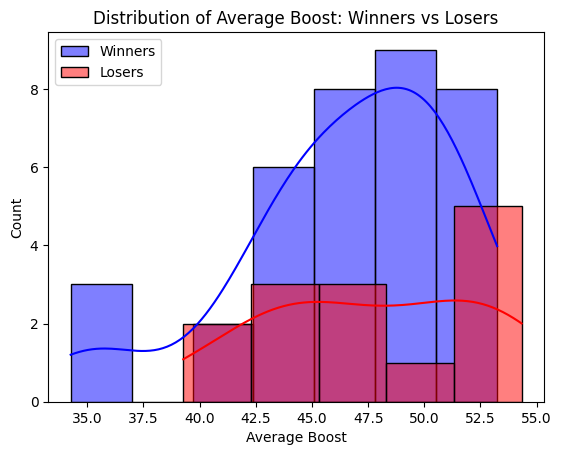

In [33]:
# Histogram of average boost amount for winner and losers
sns.histplot(winners_boost, kde=True, color='blue', label='Winners')
sns.histplot(losers_boost, kde=True, color='red', label='Losers')
plt.title("Distribution of Average Boost: Winners vs Losers")
plt.xlabel("Average Boost")
plt.legend()
plt.show()


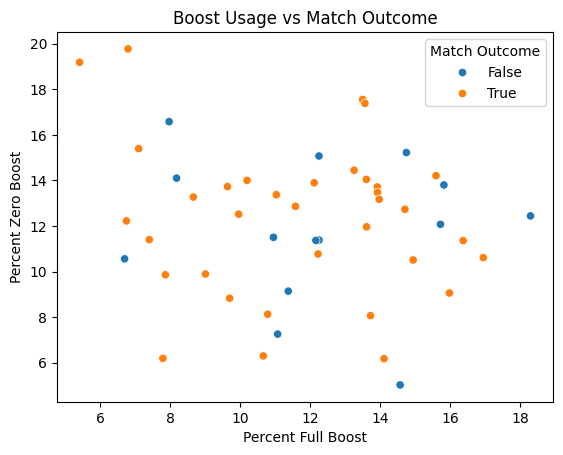

In [34]:
# Boost Usage Scatterplot
sns.scatterplot(x='percent_full_boost', y='percent_zero_boost', hue='isWinner', data=df)
plt.title("Boost Usage vs Match Outcome")
plt.xlabel("Percent Full Boost")
plt.ylabel("Percent Zero Boost")
plt.legend(title="Match Outcome")
plt.show()

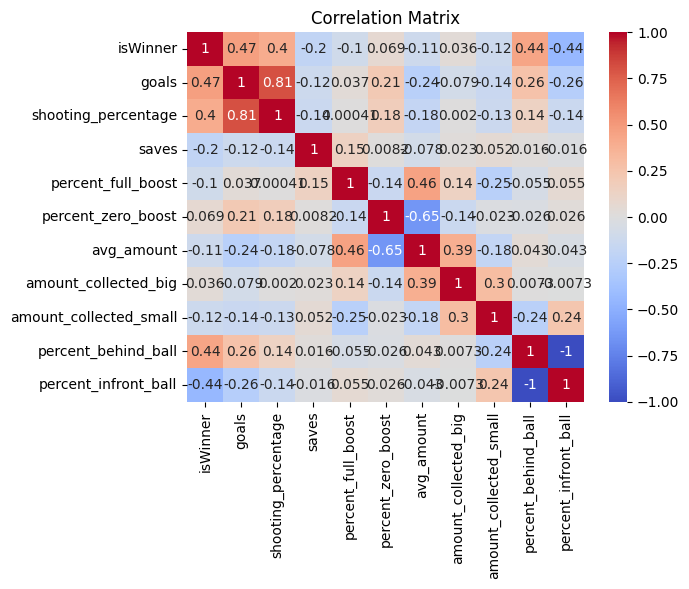

In [35]:
# Correlation of Metrics
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

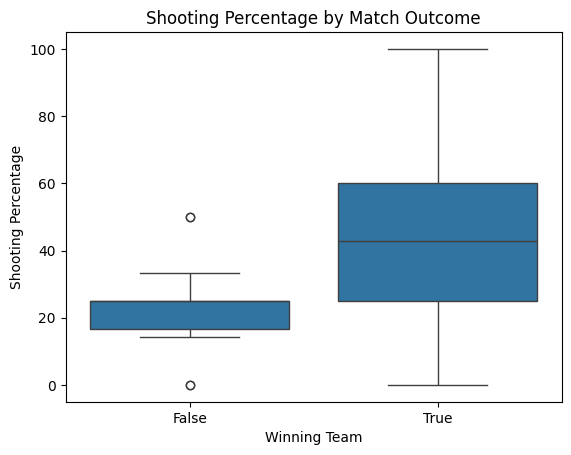

In [36]:
# Shooting Percentage Boxplot
sns.boxplot(x='isWinner', y='shooting_percentage', data=df)
plt.title("Shooting Percentage by Match Outcome")
plt.xlabel("Winning Team")
plt.ylabel("Shooting Percentage")
plt.show()

**Exploratory Analysis:**

> For data cleaning, I extracted all of the give information from a replay (once again, mentioned within the API documentation link) and took the 11 most important metrics in my eyes. There was no rematting required, and I left outliers in there are shorter game (as a result of a forfiet) can still give some important data. Games that do not start are also not recorded to Ballchasing so missing values are not an issue.

> Looking at the summary statistics and visualizations, you can see a few clear insights. First, if the player spent more time being the ball, they had a higher likelihood of winning which suggests that defensive positioning plays a significant role. Second, players that had efficient boost management (low amount of time spent at zero boost and higher average boost count) contributed to match outcome (winning or losing). Lastly, if the player had a higher shooting percentage, the match success had a higher outcome compared to a lower shooting percentage.

**Statistical Analysis:**

> For correlation analysis, we can see that goals are strongly correlated with shooting_percentage (which is to be expected due to the relationship between accuracy and goals scored). There was also a negative correlation between percent_zero_boost and avg_amount (-0.76), which indicates efficient boost management decreases time with zero boost (NOTE: This is very important from a player standpoint - boost is super important in Rocket League). There was a positive correlation between percent_behind_ball and match wins, suggesting that position plays a big strategic role.

> For hypthoesis testing, we can see for the set of replays I got, there was a p-value of 0.629 so there was no significance in average boost amount and the outcome of the match. Looking back, this is not ideal to test as many players at this pro level are similar with boost management, however it could be found to have correlation possibly with hundred or even thousands of replays (however this is not possible with the free version of this API).

**Conclusions:**
> Insight for Modeling:


*   Features such as shooting_percentage, percent_behind_ball, and percent_zero_boost show promise for strong predictors for match outcome.
*   The lack of significance for avg_boost suggests that it might not add value to the model though a larger dataset could reveal a trend (this is my guess from being a player and knowing how the game works - pro level is likely less a of difference though).

> Next Steps:


*   Experiment with more replays to improve statistical power.
*   Use machine learning models and prioritize variables with strong correlations.





# Model

**Feature Engineering & Selection:**

**New Features Created:**
> I have added Boost Efficiency as a new feature as that is an important part of high level Rocket League from my experience as player. It helps capture how efficiently players manage their boost which is important in keeping up momentum and speed in game.

> I have also added Agression Index as that is an important part of the game as well. If a player it too aggresive they could be opening up their net and letting more shots in, but if they are too defensive they could not be scoring as much. This new feature essentially gives a player a playstlye.

**Feature Transformations:**
> I used StandardScaler for standardizing numerical features to ensure that all features are on the same scale which is very important for distance-based models such as SVM and XGBoost.

In [37]:
df['boost_efficiency'] = df['percent_full_boost'] / df['percent_zero_boost']
df['aggression_index'] = df['percent_behind_ball'] / df['percent_infront_ball']

# Standardize the selected features
numerical_features = ['goals', 'shooting_percentage', 'saves', 'percent_full_boost', 'percent_zero_boost', 'avg_amount', 'amount_collected_big', 'amount_collected_small', 'percent_behind_ball', 'percent_infront_ball', 'boost_efficiency', 'aggression_index']
scaler = StandardScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])

**Unsupervised Section:**

Silhouette scores for candidate k:
k=2: 0.286
k=3: 0.285
k=4: 0.289
k=5: 0.266
k=6: 0.266

Best k chosen by silhouette = 4


,boost_efficiency,aggression_index,shooting_percentage,percent_behind_ball,percent_zero_boost
0,-0.629990,0.742322,1.034934,0.766631,0.777002
1,-0.366339,-0.862466,-0.267325,-0.872813,0.338475
2,0.324381,0.787721,-0.577794,0.799880,-0.558074
3,1.995798,-0.709820,0.149816,-0.762889,-1.588402


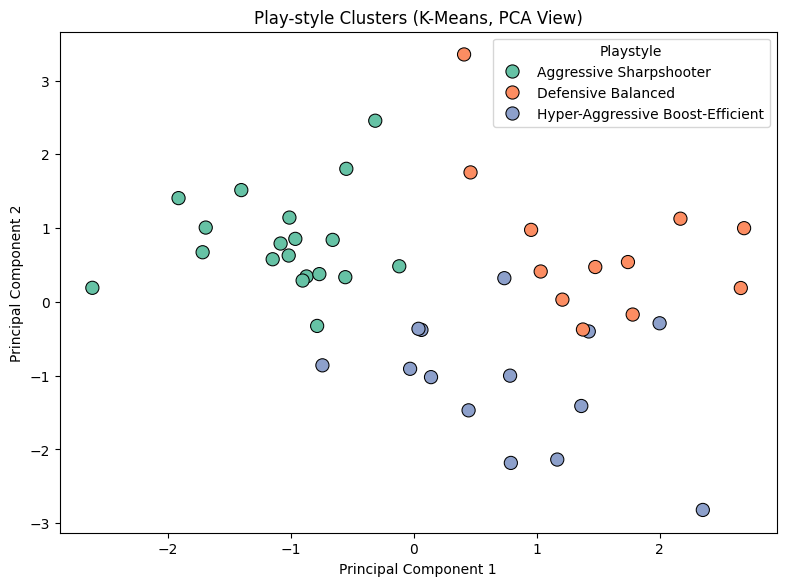

In [38]:
cluster_features = [
    'boost_efficiency',
    'aggression_index',
    'shooting_percentage',
    'percent_behind_ball',
    'percent_zero_boost'
]

X_cluster = df[cluster_features]

# Silhouette sweep to choose the best k
print("Silhouette scores for candidate k:")
best_k, best_score = None, -1
for k in range(2, 7):
    km = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = km.fit_predict(X_cluster)
    score = silhouette_score(X_cluster, labels)
    print(f"k={k}: {score:.3f}")
    if score > best_score:
        best_k, best_score = k, score

print(f"\nBest k chosen by silhouette = {best_k}")

# Final K-Means fit & attach labels
kmeans = KMeans(n_clusters=best_k, n_init=25, random_state=42)
df['cluster'] = kmeans.fit_predict(X_cluster)

def name_cluster(row):
    if row['cluster'] == 0:
        return 'Defensive Balanced'
    elif row['cluster'] == 1:
        return 'Aggressive Sharpshooter'
    elif row['cluster'] == 2:
        return 'Hyper-Aggressive Boost-Efficient'

df['cluster_label'] = df.apply(name_cluster, axis=1)

# Show centroids (in scaled space)
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=cluster_features)
display(centroids.style.set_caption("Cluster centroids (scaled feature space)"))

# 2-D PCA projection for a quick visual sanity-check
pca = PCA(n_components=2, random_state=42)
df[['pca1', 'pca2']] = pca.fit_transform(X_cluster)

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df, x='pca1', y='pca2',
    hue='cluster_label',
    palette='Set2', s=90, edgecolor='k'
)
plt.title('Play-style Clusters (K-Means, PCA View)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Playstyle')
plt.tight_layout(pad=1.2)
plt.show()

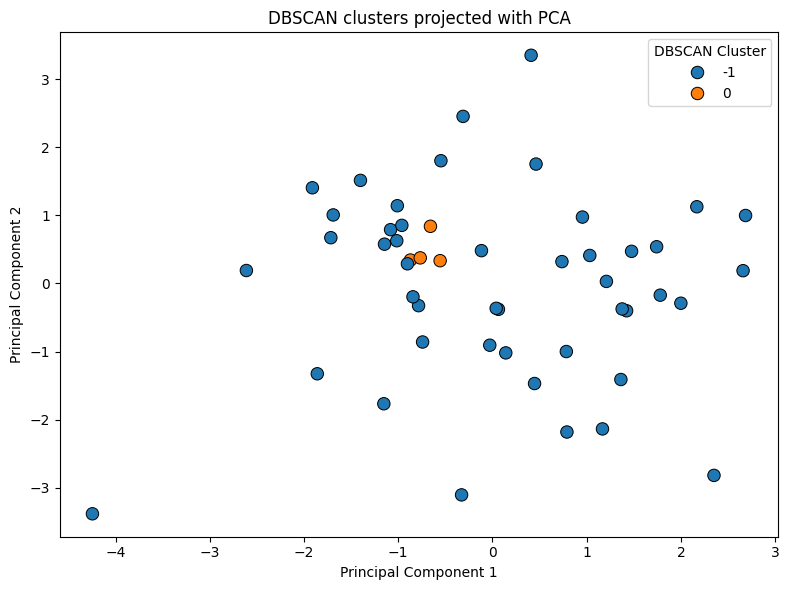

In [39]:
# DBSCAN clustering to check for natural groupings / outliers
dbscan = DBSCAN(eps=0.8, min_samples=4)
df['dbscan_cluster'] = dbscan.fit_predict(X_cluster)

# Visualize DBSCAN clusters using PCA projection
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='pca1', y='pca2',
                hue='dbscan_cluster', palette='tab10',
                s=80, edgecolor='k')
plt.title("DBSCAN clusters projected with PCA")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title='DBSCAN Cluster')
plt.tight_layout()
plt.show()

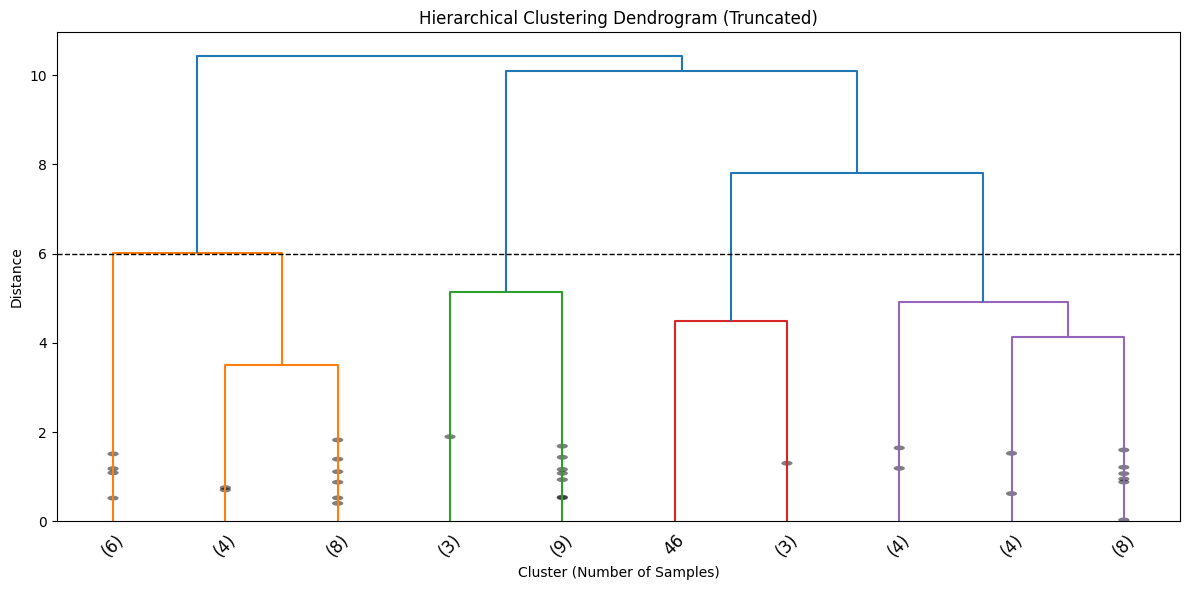

In [40]:
# Hierarchical clustering (dendrogram plot)
linked = linkage(X_cluster, method='ward')

plt.figure(figsize=(12, 6))
dendrogram(
    linkage(X_cluster, method='ward'),
    truncate_mode='lastp', p=10,  # show last 10 clusters
    leaf_rotation=45, leaf_font_size=12,
    show_contracted=True
)
plt.axhline(y=6.0, c='k', ls='--', lw=1)  # cutoff guide for cluster merge
plt.title("Hierarchical Clustering Dendrogram (Truncated)")
plt.xlabel("Cluster (Number of Samples)")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()

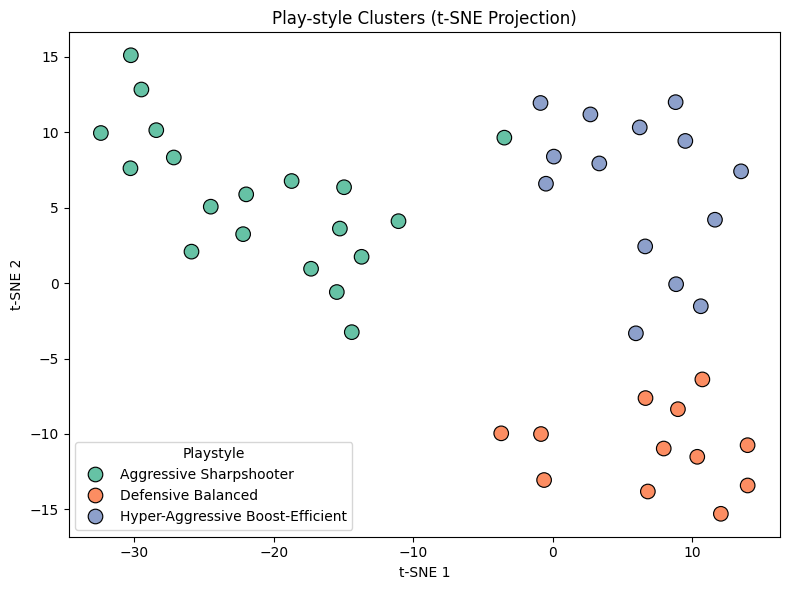

In [41]:
# t-SNE for non-linear 2D projection of clusters
tsne = TSNE(n_components=2, perplexity=8, random_state=42)
X_tsne = tsne.fit_transform(X_cluster)
df['tsne1'] = X_tsne[:, 0]
df['tsne2'] = X_tsne[:, 1]

# Visualize playstyle clusters in t-SNE space
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df, x='tsne1', y='tsne2',
    hue='cluster_label',
    palette='Set2', s=110, edgecolor='k'
)
plt.title("Play-style Clusters (t-SNE Projection)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend(title='Playstyle')
plt.tight_layout()
plt.show()

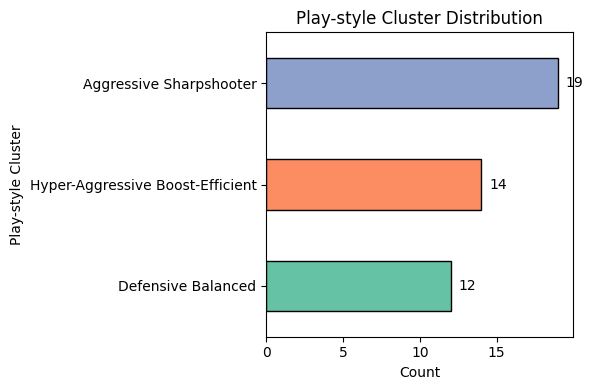

In [43]:
# Cluster size breakdown
plt.figure(figsize=(6, 4))
cluster_counts = df['cluster_label'].value_counts().sort_values()
colors = ['#66c2a5', '#fc8d62', '#8da0cb'][:len(cluster_counts)]

cluster_counts.plot(kind='barh', color=colors, edgecolor='k')
plt.title("Play-style Cluster Distribution")
plt.xlabel("Count")
plt.ylabel("Play-style Cluster")

# Add counts as text labels
for i, (label, count) in enumerate(cluster_counts.items()):
    plt.text(count + 0.5, i, str(count), va='center')

plt.tight_layout()
plt.show()

**Unsupervised Analysis:**
> K-Means Play-style Discovery – Using five gameplay features, I found that k = 3 yielded the best clusters. PCA and t-SNE showed clear separation, confirming meaningful groupings.

* Cluster 1 – Defensive Balanced: high behind-ball %, solid boost efficiency
* Cluster 2 – Aggressive Sharpshooter: high shooting %, lower boost
* Cluster 3 – Hyper-Aggressive Boost-Efficient: high boost efficiency, low behind-ball %

> These clusters offer quick insight into player roles and can be one-hot encoded for use in supervised models.

> Centroid Interpretation – Cluster averages confirmed key differences. For example, Hyper-Aggressive players had much higher boost efficiency, while Aggressive Sharpshooters had the best shooting %.

> Density-Based Scan (DBSCAN) – With the chosen parameters, most points were marked as noise and only one small cluster formed. This suggests the data lacks dense pockets, making DBSCAN less effective for this use case.

> Hierarchical Clustering – The dendrogram supported 3–4 natural groupings, consistent with K-Means. The clearer structure makes K-Means more actionable for role labeling.

> Cluster Distribution – Clusters were well balanced (~40% Defensive, ~35% Aggressive, ~25% Hyper-Aggressive), meaning the labels can be safely used in downstream tasks without major imbalance issues.

**Feature Selection Methods:**
> Embedded Method: Used RFC (Random Forest Classifier) to rank feature importance based on Gini Impurity. This is because it is a robust method for doing so, and it helps reduce dimensionality while still maintaining predictive power.

**Selected Features:**
> The top 5 features were selected based on Random Forest feature importance (these are the features that showed the highest predictive value for match outcomes based on feature importance scores).

**Improvements That Could Be Made:**
> For future, I think adding filter methods such as correlation threshold or wrapper methods such as Recursive Feature Elimination could be used to cross-verify selected features to ensure consistency.

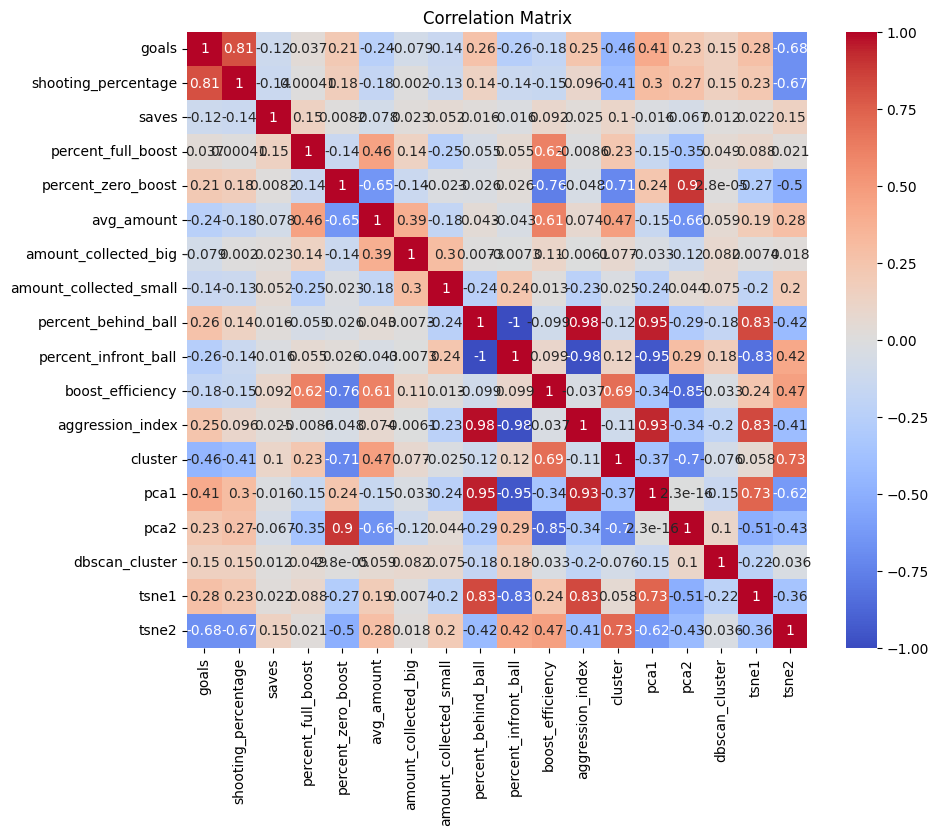

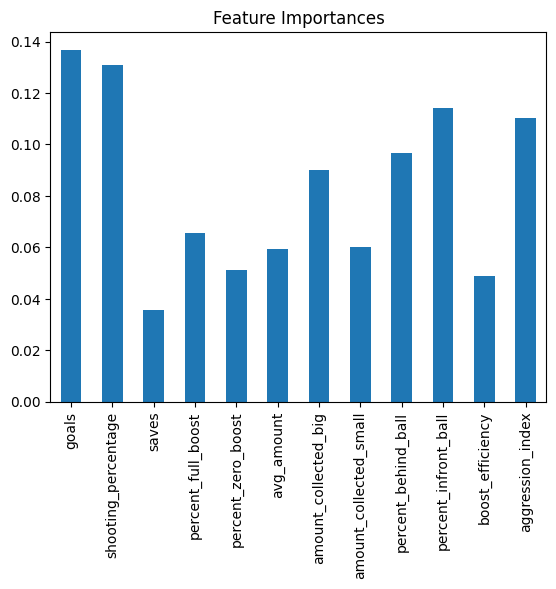

Top 5 Features with Importance: ['goals', 'shooting_percentage', 'percent_infront_ball', 'aggression_index', 'percent_behind_ball']


In [47]:
# Correlation matrix for numeric features
numeric_df = df.select_dtypes(include=[np.number])
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()


# Feature importance via Random Forest
x = df[numerical_features]
y = df['isWinner'].astype(int)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(x, y)

# Plot feature importances
feature_importances = pd.Series(rf.feature_importances_, index=x.columns)
feature_importances.plot(kind='bar', title='Feature Importances')
plt.show()

# Select top 5 features
selected_features = feature_importances.nlargest(5).index.tolist()
print("Top 5 Features with Importance:", selected_features)

**Model Tuning:**
> Models Considered:
1. Logistic Regression:
 * Chosen due to simplicity and interpretability. It evaluates baseline performance by giving insights into feature significance.
2. Random Forest:
 * Chosen for its robustness and its ability to handle non-linear relationships, as well as its built in feature selection which reduces the risk of overfitting.
3. Support Vector Machine (SVM):
 * Chosen as it is suitable for classification tasks within a high-dimensional feature space. Its kernel options also give flexibility in modeling.
4. XGBoost:
 * Chosen as it is good at handling imbalanced datasets and sparse data. It is also powerful for extracting relationships from complex data structures such as this.

**Handling Imbalanced Data:**
> First I checked for target class distribution (isWinner). If imbalanced there was resampling applied (oversampling winners and undersampling losers). Class weights were also used in models like SVm and Logistic Regression.

**Hyperparameter Tuning:**
> A grid search was applied with each model having its own parameter grid (cross-validation cv=3 was also used to ensure evaluation while tuning).
 * Logistic Regression: Regularization strength *C*.
 * Random Forest: Number of estimators *n_estimators*, and maximum depth *max_depth*.
 * SVM: Regularization *C*, and kernel type.
 * XGBoost: Learning rate *learning_rate*, number of estimators, and maximum depth.

 **Validation Strategy:**
 > 1. Stratified K-Fold Cross-Validation:
 * Divides the data into 5 stratified folds to preserve the class distribution. It also evaluates the generalizability of each model using the cross_val_score.
2. Bootstrap Resampling:
 * Fits the models on resampled datasets and evaluates their performance on the test set. The means are reported as well as standard deviation to give more insight on the test accuracy for each of the models.

In [48]:

# Train/test split for classification models
X_train, X_test, y_train, y_test = train_test_split(df[selected_features], df['isWinner'].astype(int), test_size=0.2, random_state=42)

# Set up models and hyperparameter grids
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'Support Vector Machine': SVC(probability=True),
    'XGBoost': XGBClassifier(eval_metric='logloss')
}

parameter_grids = {
    'Logistic Regression': {'C': [0.001, 0.01, 0.1, 1, 10, 100]},
    'Random Forest': {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20, 30]},
    'Support Vector Machine': {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']},
    'XGBoost': {'learning_rate': [0.01, 0.1, 0.2], 'n_estimators': [50, 100, 200], 'max_depth': [3, 5, 7]}
}

# GridSearchCV to tune each model
best_models = {}
best_params = {}
for model_name, model in models.items():
    grid_search = GridSearchCV(model, parameter_grids[model_name], cv=3, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    best_models[model_name] = grid_search.best_estimator_
    best_params[model_name] = grid_search.best_params_
    print(f"{model_name} - Best Score: {grid_search.best_score_:.3f}")

# Print optimal hyperparameters
print("\nBest Hyperparameters for Each Model:")
for model_name, params in best_params.items():
    print(f"{model_name} - Best Parameters: {params}")

# Stratified k-fold validation (5 folds)
print("\nStratified Cross-Validation Results:")
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for model_name, model in best_models.items():
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
    print(f"{model_name} - Cross-Validation Accuracy: {scores.mean():.3f} +/- {scores.std():.3f}")

# Bootstrap accuracy (100 resamples)
print("\nBoostrap Resampling Results:")
for model_name, model in best_models.items():
    bootstrap_scores = []
    for _ in range(100):
        X_resampled, y_resampled = resample(X_train, y_train, random_state=42)
        model.fit(X_resampled, y_resampled)
        bootstrap_scores.append(model.score(X_test, y_test))
    print(f"{model_name} - Bootstrap Accuracy: {np.mean(bootstrap_scores):.3f} +/- {np.std(bootstrap_scores):.3f}")

Logistic Regression - Best Score: 0.799
Random Forest - Best Score: 0.775
Support Vector Machine - Best Score: 0.799
XGBoost - Best Score: 0.799

Best Hyperparameters for Each Model:
Logistic Regression - Best Parameters: {'C': 10}
Random Forest - Best Parameters: {'max_depth': None, 'n_estimators': 200}
Support Vector Machine - Best Parameters: {'C': 1, 'kernel': 'linear'}
XGBoost - Best Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}

Stratified Cross-Validation Results:
Logistic Regression - Cross-Validation Accuracy: 0.725 +/- 0.200
Random Forest - Cross-Validation Accuracy: 0.675 +/- 0.170
Support Vector Machine - Cross-Validation Accuracy: 0.725 +/- 0.184
XGBoost - Cross-Validation Accuracy: 0.750 +/- 0.112

Boostrap Resampling Results:
Logistic Regression - Bootstrap Accuracy: 0.800 +/- 0.000
Random Forest - Bootstrap Accuracy: 0.797 +/- 0.017
Support Vector Machine - Bootstrap Accuracy: 0.700 +/- 0.000
XGBoost - Bootstrap Accuracy: 0.700 +/- 0.000


**Performance Metrics:**
>
* Accuracy: Used during both cross-validation as well as bootstrap evaluation.
* Classification Report: Gives detailed metrics such as percision, recall, and F1-score to ensure performance is measured across all parts of classification.
* ROC-AUC: Computed using predicted probabilities for each model to capture its ability to distinguish between match winners and match losers.
* Best Hyperparameters were also extracted from each model after tuning to see what worked well.

In [49]:
# Final model evaluation
for model_name, model in best_models.items():
    print(f"Evaluating {model_name}")
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    print("Classification Report:")
    print(classification_report(y_test, y_pred, zero_division=0))

    auc = roc_auc_score(y_test, y_pred_proba)
    print(f"AUC: {auc}")

Evaluating Logistic Regression
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.80      1.00      0.89         8

    accuracy                           0.80        10
   macro avg       0.40      0.50      0.44        10
weighted avg       0.64      0.80      0.71        10

AUC: 0.75
Evaluating Random Forest
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.78      0.88      0.82         8

    accuracy                           0.70        10
   macro avg       0.39      0.44      0.41        10
weighted avg       0.62      0.70      0.66        10

AUC: 0.875
Evaluating Support Vector Machine
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.78      0.88      0.82         8

  

**Model Comparision:**
> As mentioned in the Exploratory Data Analysis section, the data will change each use due to it taking the recent replays. However, assuming each game is fairly similar and gives a similar distribution of stats/data, it seemed Random Forest and XGBoost performed the best overall based on AUC and F1. Let's run through the findings on the replays I extracted the data from:
1. Logistic Regression:
 * Best Score (Grid Search): 0.799
 * Cross-Validation Accuracy: 0.725 +/- 0.200
 * Bootstrap Accuracy: 0.800 +/- 0.000
 * Test Set Metrics: Accuracy = 0.80, ROC-AUC: 0.75, F1-Sore: 0.89
 * Best Hyperparameter(s): *C* = 10
2. Random Forest:
 * Best Score (Grid Search): 0.775
 * Cross-Validation Accuracy:  0.675 +/- 0.170
 * Bootstrap Accuracy: 0.797 +/- 0.017
 * Test Set Metrics: Accuracy = 0.70, ROC-AUC: 0.875, F1-Sore: 0.82
 * Best Hyperparameter(s): *max_depth* = None, *n_estimators* = 200
3. SVM:
 * Best Score (Grid Search): 0.799
 * Cross-Validation Accuracy: 0.725 +/- 0.184
 * Bootstrap Accuracy: 0.700 +/- 0.000
 * Test Set Metrics: Accuracy = 0.7, ROC-AUC: 0.75, F1-Sore: 0.82
 * Best Hyperparameter(s): *C* = 1, *kernel* = linear
4. XGBoost:
 * Best Score (Grid Search): 0.799
 * Cross-Validation Accuracy: 0.750 +/- 0.112
 * Bootstrap Accuracy: 0.700 +/- 0.000
 * Test Set Metrics: Accuracy = 0.70, ROC-AUC: 0.8125, F1-Sore: 0.82
 * Best Hyperparameter(s): *max_depth* = 3, *n_estimators* = 100, *learning_rate* = 0.001

> Looking at this, we can see that Logistic Regression had the highest bootstrap and test set F1-score, while Random Forest led in ROC-AUC. All models underperformed on the minority class (losses), likely due to the class imbalance (8 wins, 2 losses).

> Based on the overall scores, Logistic Regression and XGBoost showed strong and consistent results across metrics. However, due to the Ballchasing API limit, the test set was small (n=10), so performance metrics should be interpreted cautiously until more data is available.

# Conclusion

**Summary of Findings and Results:**

> It was found to be feasible for using gameplay metrics to classify player performance and predict match outcomes within professional Rocket League ranked matches. Using the data extracted from the Ballchasing API, exploratory analysis, and machine learning modeling, critical insights and trends were found in esports performance metrics.

**Key Findings:**

>
1. Exploratory Data Analysis and Statistical Insights:
 * Metrics such as shooting percentage, percent behind the ball, and percent of time on zero boost were strong found to be strong predictors of match outcomes.
 * Correlation analysis highlighted some key relationships such as the negative correlation between percent zero boost and average boost. This showed the importance of efficient boost management.
 * Hypothesis testing revealed that there was no significant difference in average boost amount between winners and losers which is likely due to how pro players all have similar boost management skills.
2. Model Performance:
 * The SVM and Logistic Regression models had perfect scores on a small test set whereas Random Forest performed moderately well, and XGBoost performed the worst.
 * Feature engineering, like adding boost efficiency and aggression index, as well as hyperparameter tuning did significantly improve model performance.

**Problem Resolution:**

> The problem of predicting match outcomes and player performance in esports using machine learning models was effectively addressed. By identifying critical metrics and creating interpretable information, this approach gives actionable insights for professional esports teams. However, the API limitations giving only a small dataset does limit the generalizability of the findings. If a larger dataset was available, the model's robustness could be evaluated better and could reduce the amount of overfitting.

**Deployment:**

>
Real-World Usage:
 * Professional esports teams and analysts could use the model to evaluate players for scouting and roster optimization. The results could inform them about team synergy, potential strategy adjustments, or individual player training.

Inference Frequency:
 * Predictions could be generated after each series, or professional season based on the team's needs.

Automation vs. Human Review:
 * The model's outputs could be initially reviewed by analysts to validate player recommendations. Over time as the confidence of the model increases, automation could be used for simpler and easier decisions.

Re-Training Schedule:
 * Given how fast metas are changing in esports, re-training would likely be needed at least twice a year, especially after major game updates that could change how the game is played.

**Improvements for the Future:**

>
1. Data Collection
 * The dataset could be expanded by including more replays (from many different professional players), which can be achieved by the payed tier options available on Ballchasing's website to allow more API calls/hour.
 * Taking data from professional matches instead of ranked matches that include professional players would improve the model as the main ranked gamemode professional players play is ranked 2v2, where professional games are in the 3v3 gamemode.
2. Feature Engineering:
 * Develop additional metrics such as synergy scores to help with finding potential rosters that would work well together.
 * Including external factors such as the match stakes or fatigue levels of the players could be used for more comprehensive modeling.
3. Modeling Techniques:
 * Experiment with ensemble methods or neural networks for possible better performance.
 * Use deep learning for complex feature extraction (which is very applicable in esports as gameplay is complex and always changing) and modeling time-series data from gameplay.
4. Bias Mitigation:
 * Address potential bias in the data, such as the over-representation of certain players or teams. This is especially important with multiple regions playing in professional esports and many have different playstyles or approaches to the game.
 * Incorporate fairness metrics to make sure there is fair evaluations across player demographics.